In [ ]:
import getpass
import os
import math
import numexpr
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig


In the above cell we've imported the necessary packages. We'll explain the various libraries and functions as they become relevant later on, but first we'll start by defining a tool. We can define a tool the same way we define a standard python function, it just needs to take a string, or multiple strings as an input, and also return a string. Since we learned LLMs can be bad at math, let's start by creating a calculator tool. 

In [2]:
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )


In order for our function to work as a tool with the LangGraph framework, it is vital we have type hints and and doc-string explaining what the function does. An LLM would have no idea how to interact with this same tool if we wrote our code like this:


```python
def calculator(expression):
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )
```

If you have a strong desire to learn more about the `numexpr` package being used, you can find the github repo for it [here](https://github.com/pydata/numexpr), but all you really need to understand is that it's a faster `numpy`. 

Let's test out our calculator below.

In [3]:
calculator('3.8-3.11')

'0.69'

In [4]:
calculator('(2021**(1/2)) + (2024**(1/3))')

'57.60494067281279'

Many tools are pre-built for us by the open-source community and don't require coding something from scratch. Next, we're going to take a look at a pre-built websearch tool. In order for it to work, you need to have an API key in your environmental variables. Hopefully you set that up ahead of time. Run the cell below and copy and paste it in. 

In [10]:
if os.environ.get("TAVILY_API_KEY") is None:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")


You can play around with it in the cell below.

In [11]:
TavilySearch(max_results=5).invoke('skyline chili')

{'query': 'skyline chili',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Skyline Chili - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Skyline_Chili',
   'content': 'Skyline Chili is a chain of casual dining restaurants founded in 1949 by Greek immigrant Nicholas Lambrinides. It is known for its signature dishes of cheese coneys and 3-ways, and its secret spice blend of Cincinnati chili.',
   'score': 0.9521889,
   'raw_content': None},
  {'title': 'Skyline Chili',
   'url': 'https://locations.skylinechili.com/skyline-chili-a0254bd3f93f',
   'content': 'Skyline Chili is famous for its secret recipe chili, Cheese Coneys and Ways. Find locations, menu, hours and online ordering for this fast, friendly and delicious dine-in and drive-thru service.',
   'score': 0.8934678,
   'raw_content': None},
  {'title': 'SKYLINE CHILI - Updated May 2025 - 78 Photos & 72 Reviews - Yelp',
   'url': 'https://www.yelp.com/biz/skyline-chili-columbus-12',
   '

Zac is going to provide you an endpoint url and a key to an Azure OpenAI GPT-4o-mini deployment. This resource will be torn down at the completion of today's session. It is **not** deployed in a GAIG account, so please do not use it for any GAIG things in the next 45 minutes.

In [5]:
if "AZURE_OPENAI_API_KEY" not in os.environ:
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass(
        "Enter your AzureOpenAI API key: "
    )
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://gaig-gpt.openai.azure.com/"

Below we'll instantiatee our model. Changing the deployment will not do anything as there is currently only one model deployed at the endpoint. 

In [6]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_version="2025-01-01-preview",
    temperature=0,
    max_tokens=8192,
    timeout=30,
    max_retries=2,
)

Do a quick test to validate your connectivity. 

In [9]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates plain English into white-collar corporate speak that uses phrases like 'synergy' and 'stack hands' and is appropriate for email. Translate the user sentence.",
    ),
    ("human", "Bill is an absolute clown. Listening to him on the morning stand-up makes me want to bash my face into my keyboard."),
]
ai_msg = llm.invoke(messages)
print(ai_msg.content)

Subject: Feedback on Morning Stand-Up

Dear Team,

I wanted to take a moment to share my thoughts regarding our recent morning stand-up sessions. While I appreciate the diverse perspectives that each team member brings to the table, I find that some of the commentary can be a bit distracting. It may be beneficial for us to streamline our discussions to ensure we maintain focus and drive towards our objectives more effectively.

Looking forward to collaborating on enhancing our meeting dynamics.

Best regards,  
[Your Name]


Now we'll begin assembling our agent. The first thing we'll need to do is "bind" the tools to our LLM. 

In [17]:
tavily_search = TavilySearch()
tools =[tavily_search, calculator]
llm_with_tools = llm.bind_tools(tools)

In layman's terms, binding the tools allows the LLM to know what tools it has access to, what they do, and what arguments they take. It gets this from the doc-string and type hints, which we mentioned earlier as being important. 

A full description that dives through all the layers of abstraction, can be found at this stackoverflow link. 

https://stackoverflow.com/questions/79375332/how-does-llm-bind-tools-work-in-langchain

Now let's take our LLM, with tools bound to it, and make it an "assistant". 

In [13]:

sys_msg = SystemMessage(content="You are a helpful assistant tasked with helping a user search for facts and perform arithmetic. Address the user as 'sir underwriter`. Keep it gangster.")
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Let's talk a little bit about what is going on with the 'state' in the above code. It's important to remember that language models are completely stateless, meaning they don't remember anything. This might seem odd, since when you converse with Chat-GPT it certainly seems like it remembers what it has previously said to you. 

The reality is that each interaction with the model, the entirety of your prior conversation is passed in the prompt. So if you tell Chat-GPT to go by a different name, and later it "remembers" it's new name, it is actually because the prompt passed to it looked something like this. 

```python
messages = 
[
    {"role":"system",
    "content":"You are a helpful assistant named ChatGPT."},
    {"role":"user",
    "content":"Today I want you to call yourself Mr. Chat."},
    {"role":"assistant",
    "content":"Okay I will go by Mr. Chat."},
    {"role":"user",
    "content":"What is your name?"}
]
```

In a ReAct Agent our prompt would look something like below. It is expecting 4 inputs to be injected. 'Tools' contains the name of each tool, what the doc-string says it does, and the arguments it takes. 'Tool names' is similar, but without all the description and literally just the names. 'Input' is the question we're going to ask our agent. 'Agent Scratchpad' will be updated with each action the agent takes. It works similarly to the "memory" in the chat above and will allow the agent to see thing it has previously done, like calling tools, and what the inputs and outputs of those steps were. 

```python
"""
Answer the following questions as best you can. You have access to the 
following tools:

{tools}

Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action

... (this Thought/Action/Action Input/Observation can repeat N times)

Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}

Thought:{agent_scratchpad}
"""
```

MessagesState is a structure provided by LangGraph to keep track of the ongoing conversation messages. It will accumulate our user and assistant messages so we can pass the full dialogue to the model each turn.

The idea behind LangGraph as a framework, is that instead of writing a prompt like what we see above, which can easily go off the rails, it uses a graph to constrain an agent into a series of steps with pre-defined transitions. Let's start to assemble our tools and assistant into a graph representation. 

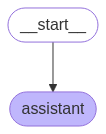

In [15]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")

react_graph = builder.compile()
react_graph


The above gets us going. We know every time we use the agent we need to start by passing a question to our assistant, but we're missing our tools.

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


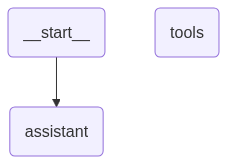

In [ ]:
builder.add_node("tools", ToolNode(tools))

react_graph = builder.compile()
react_graph

Our tools hanging out by themselves completely disconnected doesn't do us much good. 

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


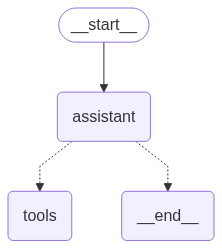

In [19]:
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

react_graph = builder.compile()
react_graph


This is closer. We go from `__start__` to `assistant` then conditionally go to `tools` or `__end__` as indicated by the dashed line, but notice how are `tools` aren't passing anything back to the `assistant`? This is not conditional, it should happen each time a tool is called. 

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


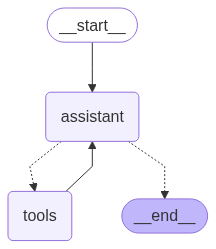

In [20]:
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
react_graph

That looks better. Tools and assistants does form a loop though. When you start to play around with the agent below, you'll see that it will try to correct itself when it incorrectly uses a tool. It can usually self-refine it's errors within a couple iterations, but let's not even risk falling into an infinite loop. Below I've added one final bit of code to set a recursion limit. Feel free to change the content of the human message and play around with your agent. 

In [ ]:
config = RunnableConfig(recursion_limit=10)

messages = [HumanMessage(content="what is the square root of the year victor adewopo finished his masters degree at the university of cincinnati plus the cube root of the year Nasser Mooman appeared on an AI podcast for CDO Magazine")]
messages = react_graph.invoke(input={"messages": messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the square root of the year victor adewopo finished his masters degree at the university of cincinnati plus the cube root of the year Nasser Mooman appeared on an AI podcast for CDO Magazine
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_F0NKimDz1nSu0f8hB2Qgh4jz)
 Call ID: call_F0NKimDz1nSu0f8hB2Qgh4jz
  Args:
    query: Victor Adewopo masters degree University of Cincinnati year
    search_depth: basic
  tavily_search (call_UHxMRLoRic5JAKykPlBk3HzO)
 Call ID: call_UHxMRLoRic5JAKykPlBk3HzO
  Args:
    query: Nasser Mooman AI podcast CDO Magazine year
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "Victor Adewopo masters degree University of Cincinnati year", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Vict